In [1]:
%matplotlib widget
# %matplotlib notebook doesn't work on vscode

import matplotlib.pyplot as plt
import numpy as np 
from numba import jit
from numpy import sin, pi
from pathlib import Path

%reload_ext autoreload
%aimport Funcs
%aimport visualization
%aimport species_transport
%aimport parameters
from parameters import *
from fluid_flow import dt_fluid_flow

In [19]:
N, M = 50,50
dx, dy, Ns_c, Nc_lw = parameters.set_resolution(N,M)
dt = dt_fluid_flow(dx, Fo=0.3)

In [20]:
# load the velocity field:
datap = Path('data/vel_field') / 'N{}M{}.npy'.format(N,M)
u,v = np.load(datap)

In [4]:
CH4, O2, N2, H2O, CO2, T = np.zeros((6,N,M))
O2[:] = .233
N2[:] = .767
T[:] = 300
Y = np.array([CH4, O2, N2, CO2, H2O])

In [5]:
%autoreload 1
from Funcs import advance_adv_diff_RK4
from species_transport import set_BCs, set_Temp_BC

#Nt = 100
#Y_t = np.zeros((*Y.shape, Nt))
#T_t = np.zeros((*T.shape, Nt))

@jit(nopython=True)
def evolve_species(Nt, Y, T):
    
    nspec = Y.shape[0]
    Y = set_BCs(Y, Ns_c, Nc_lw)
    
    for n in range(Nt):
        for k in range(nspec):
            
            if k < nspec-1:
                Y[k] = advance_adv_diff_RK4(Y[k], dt, u, v, dx, dy, nu)
                
            else:
                # normalization condition:
                Y[k] = 1 + Y[k] - np.sum(Y, axis=0)
        
        # apply BCs
        Y = set_BCs(Y, Ns_c, Nc_lw)            
        T = set_Temp_BC(T, Ns_c, Nc_lw)
        
        #Y_t[:,:,:,n] = Y
        #T_t[:,:,n]   = T
        
    return Y, T

In [7]:
Nt = 1000
Y, T = evolve_species(Nt, Y, T)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
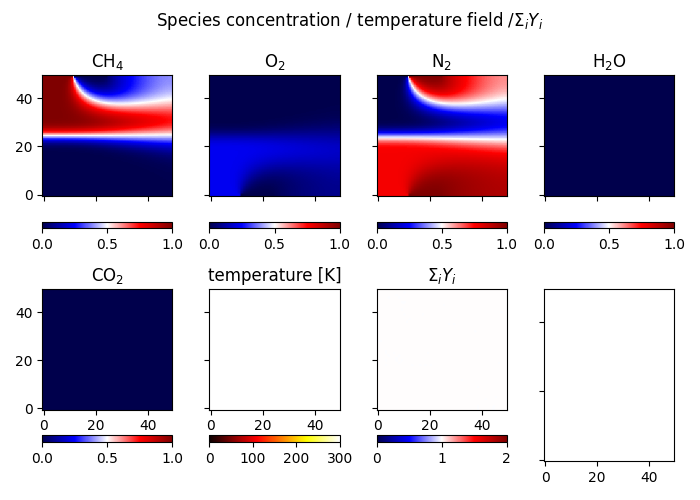

In [8]:
from visualization import plot_species_overview
%autoreload 1
fig, axs =plt.subplots(2, 4, figsize=(7,5.),sharex=True, sharey=True)
plot_species_overview(Y,T, axs=axs)

In [9]:

data_sp = Path('data/species') / 'N{}M{}.npy'.format(N,M)
species_data = np.zeros((Y.shape[0] + 1, *Y.shape[1:]))
species_data[:-1,:, :] = Y
species_data[-1, :, :] = T
np.save(data_sp, species_data)


## What is the diffusion zone length?

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
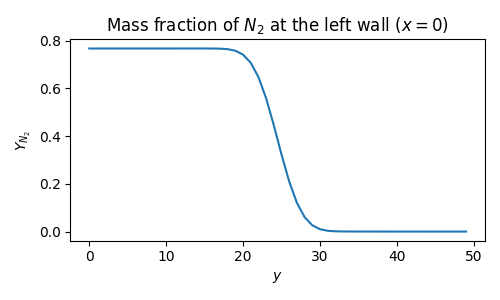

In [16]:
left_wall_N2 = Y[2,0,:]
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(left_wall_N2)
ax.set_xlabel('$y$')
ax.set_ylabel('$Y_{N_2}$')
ax.set_title('Mass fraction of $N_2$ at the left wall ($x=0$)')
plt.tight_layout()